In [3]:
# Import CVX and numpy libraries
import random
import cvxpy as cvx
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import shuffle
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [63]:
# Function to generate a random problem, in 
# n dimensions with npoints number of points
def generate(n,npoints):
    # Set the limits of the domain
    origA = np.full((n+1,n),-5.)
    rangA = np.full((n+1,n), 10.)
    origP = np.full((npoints,n),-5.)
    rangP = np.full((npoints,n), 10.)

    # Construct the anchor points
    a = np.random.rand(n+1,n)
    a = origA + np.multiply(a,rangA)

    # Construct the sensor points
    p = np.random.rand(npoints,n)
    p = origP + np.multiply(p,rangP)

    #Set up some problem characteristics
    if(n > 1): # 2-D and 3-D cases
        minConstr = 3 # Minimum number of constraints per point
        maxConstr = 4 # Approximately maximum number of constraints
        minAnchConstr = 2 # Minimum number of anchor constraints
    else:
        minConstr = 2 # Minimum number of constraints per point
        maxConstr = 3 # Approximately maximum number of constraints
        minAnchConstr = 1 # Minimum number of anchor constraints
    
    # Build the adjacency matrix
    adjacency = np.full((npoints+n+1,npoints+n+1),-1.)

    anchList = [i for i in range(n+1)]
    pointList = [i for i in range(npoints)]
    off = n + 1

    for i in range(npoints):
        random.shuffle(anchList)
        random.shuffle(pointList)
        # Set anchor constraints
        numAnch = random.randint(minAnchConstr,minConstr)
        for l in range(numAnch):
            adjacency[anchList[l],i+off] = np.linalg.norm(a[anchList[l]] - p[i])
            adjacency[i+off,anchList[l]] = adjacency[anchList[l],i+off]
        # Count number of constraints already set for this point
        countConstr = 0
        for l in range(npoints+off):
            if(adjacency[l,i+off] > 0):
                countConstr = countConstr + 1
        # Set point constraints
        if(minConstr - countConstr >= 0):
            numPoint = random.randint(minConstr-countConstr,3)
            count = numPoint
            l = 0
            while(count > 0 and l < len(pointList)):
                # If the point with which to set the constraint is different
                if(pointList[l] != i):
                        # Make sure that the node to connect does not have too many constraints
                        countConstr = 0
                        for k in range(npoints+off):
                            if(adjacency[k,pointList[l]+off] > 0):
                                countConstr = countConstr + 1
                        if(countConstr < maxConstr):
                            # Add the new constraint
                            adjacency[pointList[l]+off,i+off] = np.linalg.norm(p[pointList[l]] - p[i])
                            adjacency[i+off,pointList[l]+off] = adjacency[pointList[l]+off,i+off]
                            count = count - 1
                l = l + 1
    return [a, p, adjacency]

# Function to generate a problem with sensors inside
# the convex hull, in n dimensions with npoints number 
# of points
def generate_inside_hull(n,npoints):
    # Set the limits
    origA = np.full((n+1,n),-5.)
    rangA = np.full((n+1,n), 10.)
    origP = np.full((npoints,n),-5.)
    rangP = np.full((npoints,n), 10.)
    
    if(n == 1):
        a = np.array([-6, 6])
    elif(n == 2):
        a = np.array([[-6, 15], [-6, -15], [8, 0]])
    elif(n == 3):
        a = np.array([[-6, 15,-10], [-6, -15,-10], [8, 0, -10], [0, 0, 10]])
    # Construct the sensor points
    p = np.random.rand(npoints,n)
    p = origP + np.multiply(p,rangP)

    adjacency = np.full((npoints+n+1,npoints+n+1),-1.)

    if(n > 1):
        minConstr = 3
        maxConstr = 4
        minAnchConstr = 2
    else:
        minConstr = 2
        maxConstr = 3
        minAnchConstr = 1

    anchList = [i for i in range(n+1)]
    pointList = [i for i in range(npoints)]
    off = n + 1

    for i in range(npoints):
        random.shuffle(anchList)
        random.shuffle(pointList)
        # Set anchor constraints, between 1 and 3
        numAnch = random.randint(minAnchConstr,minConstr)
        for l in range(numAnch):
            adjacency[anchList[l],i+off] = np.linalg.norm(a[anchList[l]] - p[i])
            adjacency[i+off,anchList[l]] = adjacency[anchList[l],i+off]
        # Count number of constraints already set for this point
        countConstr = 0
        for l in range(npoints+off):
            if(adjacency[l,i+off] > 0):
                countConstr = countConstr + 1
        # Set point constraints, between 0 and 3
        if(minConstr - countConstr >= 0):
            numPoint = random.randint(minConstr-countConstr,3)
            count = numPoint
            l = 0
            while(count > 0 and l < len(pointList)):
                if(pointList[l] != i):
                        countConstr = 0
                        for k in range(npoints+off):
                            if(adjacency[k,pointList[l]+off] > 0):
                                countConstr = countConstr + 1
                        if(countConstr < maxConstr):
                            adjacency[pointList[l]+off,i+off] = np.linalg.norm(p[pointList[l]] - p[i])
                            adjacency[i+off,pointList[l]+off] = adjacency[pointList[l]+off,i+off]
                            count = count - 1
                l = l + 1
    return [a, p, adjacency]

In [10]:
# Note that the summations are unrolled for the ease of coding.
# The objective function is for the distances d11, d12, d22, d23, dhat12

# We update the objective function seen with two sensors and three anchors
def SNL(Y, x, y, anchors, adjacency, n, npoints):
    off = n + 1
    sum_obj = 0.
    constr  = 0.
    
    for j in range(off,off+npoints):
        x_j = x[j-off]
        y_j = y[j-off]
        
        # Add the anchor constraints
        for k in range(off):
            if(adjacency[k,j] > 0.):
                #d_jk
                sum_obj += (np.dot((anchors[k]-x_j),(anchors[k]-y_j)) - adjacency[k,j]**2)**2
                
        # Add the point to point constraints
        for i in range(off,off+npoints):
            if(adjacency[i,j] > 0.):
                #d_ij
                x_i = x[i-off]
                y_i = y[i-off]
                sum_obj += (np.dot((x_i - x_j),(y_i - y_j)) - adjacency[i,j]**2)**2

        # Constraints
        constr += x_j - y_j
        
    # Construct the problem
    ext_lagrangian = sum_obj - np.dot(Y,constr) + (beta / 2.) * np.linalg.norm(constr,2)**2

    return ext_lagrangian

# Here, we perform the gradient of the objective function
# Note that we keep the gradients for the two different
# sensors separate and stored in sum_x[0] and sum_x[1]
# respectively
def dSNLx(Y, x, y, anchors, adjacency, n, npoints):
    off = n + 1
    sum_obj = 0.
    
    grad = np.zeros((npoints, n))
    
    for j in range(off,off+npoints):
        x_j = x[j-off]
        y_j = y[j-off]
        
        # Add the anchor constraints
        for k in range(off):
            if(adjacency[k,j] > 0.):
                #d_jk
                grad[j-off] -= 2*(np.dot((anchors[k]-x_j),(anchors[k]-y_j)) - adjacency[k,j]**2) * (anchors[k]-y_j)
                
        # Add the point to point constraints
        for i in range(off,off+npoints):
            if(adjacency[i,j] > 0.):
                #d_ij
                x_i = x[i-off]
                y_i = y[i-off]
                grad[j-off] -= 2*(np.dot((x_i - x_j),(y_i - y_j)) - adjacency[i,j]**2) * (y_i - y_j)
        
        # Construct the problem
        grad[j-off] += - Y + (beta) * (x_j-y_j)
    
    return grad

def dSNLy(Y, x, y, anchors, adjacency, n, npoints):
    off = n + 1
    sum_obj = 0.
    
    grad = np.zeros((npoints, n))
    
    for j in range(off,off+npoints):
        x_j = x[j-off]
        y_j = y[j-off]
        
        # Add the anchor constraints
        for k in range(off):
            if(adjacency[k,j] > 0.):
                #d_jk
                grad[j-off] -= 2*(np.dot((anchors[k]-x_j),(anchors[k]-y_j)) - adjacency[k,j]**2) * (anchors[k]-x_j)
                
        # Add the point to point constraints
        for i in range(off,off+npoints):
            if(adjacency[i,j] > 0.):
                #d_ij
                x_i = x[i-off]
                y_i = y[i-off]
                grad[j-off] -= 2*(np.dot((x_i - x_j),(y_i - y_j)) - adjacency[i,j]**2) * (x_i - x_j)
        
        # Construct the problem
        grad[j-off] += Y - (beta) * (x_j-y_j)
    
    return grad

def updatePos(x,y,alpha, direction,gradientOp):
    xupdate = np.copy(x)
    yupdate = np.copy(y)
    if(gradientOp == 'x'):
        xupdate -= alpha * direction
    else:
        yupdate -= alpha * direction
    return [xupdate,yupdate]
            

# Updated steepest descent where we perform it twice for the two
# different sensors
def steepest_descent(Y, xin, yin, a, adjacency, n, npoints, niter, gradientOp):
    x = np.copy(xin)
    y = np.copy(yin)
    
    for i in range(niter):
        if(gradientOp == 'x'):
            direction = dSNLx(Y, x, y, a, adjacency, n, npoints)
        else:
            direction = dSNLy(Y, x, y, a, adjacency, n, npoints)

        alpha = 1.
        for j in range(npoints):
            [xupdate,yupdate] = updatePos(x, y, alpha, direction, gradientOp)

            while(SNL(Y, xupdate, yupdate, a, adjacency, n, npoints) > SNL(Y, x, y, a, adjacency, n, npoints) \
                  - 0.5 * alpha * np.dot(direction[j], direction[j])):
                    if alpha < 1e-5:
                        break
                    alpha *= 0.9
                    [xupdate,yupdate] = updatePos(x, y, alpha, direction, gradientOp)

        [x, y] = updatePos(x, y, alpha, direction, gradientOp)
    
    return [x, y]

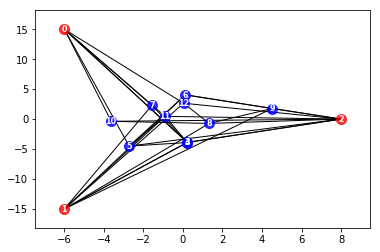

In [64]:
# Generate a problem and plot its graph representation
n = 2
npoints = 10
[a,p,adjacency]=generate_inside_hull(n,npoints)

if(n == 2):
    G=nx.Graph()

    for i in range(n+1):
        G.add_node(i,pos=a[i])

    for i in range(npoints):
        G.add_node(n+1+i,pos=p[i])

    pos=nx.get_node_attributes(G,'pos')

    nx.draw_networkx_nodes(G,pos,
                           nodelist=[i for i in range(n+1)],
                           node_color='r',
                           node_size=100,
                           alpha=0.8,
                           with_labels=True)
    nx.draw_networkx_nodes(G,pos,
                           nodelist=[i for i in range(n+1,npoints+n+1)],
                           node_color='b',
                           node_size=100,
                           alpha=0.8,
                           with_labels=True)
    for i in range(npoints+n+1):
        for j in range(n+1,npoints+n+1):
            if(adjacency[j,i] > 0.):
                G.add_edge(i,j)

    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos,font_color='w',font_size=8,font_weight='bold')
    plt.draw()  # pyplot draw()

In [ ]:
# Run tests for a random generated problem
sumNorm = 0.
for runs in range(20):
    # Define the problem
    n = 2
    npoints = 10
    [a,p,adjacency]=generate_inside_hull(n,npoints)

    beta  = 1.
    niter = 100

    # Run ADMM
    Y = np.random.rand(n)
    y_points = np.random.rand(npoints,n)
    x_points = np.random.rand(npoints,n)

    res = np.zeros(niter)

    for it in range(niter):
        [x_points, y_points] = steepest_descent(Y, x_points, y_points, a, adjacency, n, npoints, 15, 'x')
        [x_points, y_points] = steepest_descent(Y, x_points, y_points, a, adjacency, n, npoints, 15, 'y')
        for j in range(npoints):
            Y -= beta*(x_points[j] - y_points[j])
            res[it] += np.dot(x_points[j]-p[j],x_points[j]-p[j])
        if(np.dot(Y,Y) < 0.05):
            break
    sumNorm+=np.linalg.norm(x_points - p)**2
    print('Problem ', runs, ' solved')

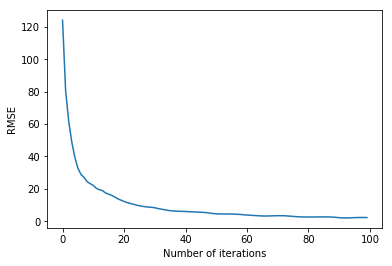

In [61]:
plt.plot(range(res.size),res)
plt.ylabel('RMSE')
plt.xlabel('Number of iterations')
plt.show()